# Dinámica del Cluster Abell 1882

En primer lugar, se procedió a cargar todas las librerías que se utilizarán en el programa:

In [1]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.table import Table, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
dataframe = pd.read_csv(r"C:\Users\amrd_\Documents\Galaxy Clusters\abell1882.csv")

In [3]:
result = pd.read_csv(r"C:\Users\amrd_\Documents\Galaxy Clusters\result.csv")
result = result.rename(columns={'z':'Redshift','ra':'RA','dec':'DEC'})

In [4]:
# Copia del dataframe sin considerar la columna de Object Name
dff=dataframe[['RA','DEC','Redshift']]
df = dff.dropna()
df

,RA,DEC,Redshift
0,213.80917,-0.50111,0.136700
6,213.81153,-0.49305,0.145314
13,213.80209,-0.51382,0.141000
16,213.81811,-0.48521,0.138000
24,213.82917,-0.50611,0.135000
...,...,...,...
10270,213.94710,-0.98006,0.152682
10301,214.02611,-0.95104,0.138000
10305,213.95360,-0.97937,1.007610
10310,214.07670,-0.92315,0.681938


In [5]:
gama = pd.read_csv(r"C:\Users\amrd_\Documents\Galaxy Clusters\gama.csv")

In [6]:
min_zsp = 0.133
max_zsp = 0.144

In [7]:
galex = pd.read_csv(r"C:\Users\amrd_\Documents\Galaxy Clusters\galex.csv")
galex = galex.rename(columns={'zspec':'Redshift','RAJ2000':'RA','DEJ2000':'DEC'})

En este caso, se accedió a la lista de catálogos del Data Release 12 (DR12) del Sloan Digital Sky Surveys (SDSS):

In [8]:
catalog_list_sdss = Vizier.find_catalogs('SDSS DR12')
for k, v in catalog_list_sdss.items():
    print(k, ': ', v.description)

V/147 :  The SDSS Photometric Catalogue, Release 12 (Alam+, 2015)
J/ApJ/807/178 :  Newly rich galaxy clusters identified in SDSS-DR12 (Wen+, 2015)
J/ApJ/835/161 :  A cosmic void catalog of SDSS DR12 BOSS galaxies (Mao+, 2017)
J/ApJ/888/85 :  Ghostly strong Lya absorbers in SDSS DR12 (Fathivavsari, 2020)
J/ApJ/901/93 :  Model atmosphere analysis of hot WDs from SDSS DR12 (Bedard+, 2020)
J/ApJS/225/23 :  Compact groups of galaxies from SDSS-DR12 (MLCG) (Sohn+, 2016)
J/ApJS/228/9 :  Physical parameters of ~300000 SDSS-DR12 QSOs (Kozlowski, 2017)
J/ApJS/229/39 :  Narrow line Seyfert 1 galaxies from SDSS-DR12 (Rakshit+, 2017)
J/A+A/583/A86 :  DB white dwarfs in SDSS DR10 and DR12 (Koester+, 2015)
J/A+A/596/A14 :  Group catalogues of the local universe (Saulder+, 2016)
J/PASP/130/H4203 :  Newly spectroscopically confirmed DB white dwarfs (Kong+, 2018)
J/MNRAS/452/4153 :  SDSS DR12 QSOs [OIII] doublet (Albareti+, 2015)
J/MNRAS/455/3413 :  New white dwarf and subdwarf stars in SDSS DR12 (Keple

Aquí se procedió a realizar un query al catálogo V/147 en la región desde el centro del Cúmulo Abell 1882 hasta su radio de 45 arcmin:

In [9]:
coordinates = "14h56m00s +19d53m00s"
results_test_sdss = Vizier.query_region(coordinates, radius="0d45m0s", catalog='V/147')
print(results_test_sdss)

TableList with 1 tables:
	'0:V/147/sdss12' with 23 column(s) and 50 row(s) 


In [10]:
# Nombres de las columnas de la tabla del catálogo
print(results_test_sdss[0].colnames)

['RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class', 'SDSS12', 'm_SDSS12', '_tab1_18', 'Q', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '__zph_']


Se definió un filtro para acceder a las columnas que son de interés del query al SDSS DR12, que son los datos de las galaxias (¨class¨ = 3) que corresponden a las Coordenadas Ecuatoriales J2000 (¨RA_ICRS¨ y ¨DE_ICRS¨ ambas en grados °), los redshifts (zsp) y las magnitudes en diferentes filtros (u, g, r, i y z) junto con sus errores respectivos.

In [11]:
v1 = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'zsp','umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag'],
            column_filters={'class': '==3', 'mode': '==1'})

In [12]:
results_coma_sdss12 = v1.query_region(coordinates, radius='0d45m0s', catalog='V/147')
print(results_coma_sdss12)

TableList with 1 tables:
	'0:V/147/sdss12' with 13 column(s) and 50 row(s) 


In [13]:
# El resultado fue una tabla con los datos respectivos correspondientes a 50 galaxias
sdss_dr12 = results_coma_sdss12[0]

In [14]:
# Se convirtió la tabla de Astropy en un dataframe y se renombraron las columnas respectivas
sdss = pd.DataFrame(np.array(sdss_dr12))
sdss = sdss.rename(columns={ 'zsp': 'Redshift','DE_ICRS': 'DEC', 'RA_ICRS': 'RA'})

In [15]:
catalog_list_sdss2 = Vizier.find_catalogs('SDSS DR8')
for k, v in catalog_list_sdss2.items():
    print(k, ': ', v.description)

II/306 :  The SDSS Photometric Catalog, Release 8 (Adelman-McCarthy+, 2011)
J/ApJ/738/79 :  SDSS-DR8 BHB stars in the Milky Way's halo (Xue+, 2011)
J/ApJ/765/12 :  Carbon stars and DQ white dwarfs from SDSS-DR7+DR8 (Green, 2013)
J/ApJ/775/116 :  z<0.06 active black hole galaxies from SDSS-DR8 (Reines+, 2013)
J/ApJ/785/104 :  redMaPPer. I. Algorithm applied to SDSS DR8 (Rykoff+, 2014)
J/ApJ/809/146 :  SDSS-DR8 isolated low-mass galaxies (Bradford+, 2015)
J/ApJS/215/24 :  Census of blue stars in SDSS DR8 (Scibelli+, 2014)
J/ApJS/223/20 :  SDSS-DR8 galaxies classified by WND-CHARM (Kuminski+, 2016)
J/ApJS/244/22 :  SDSS DR8 redMaPPer clusters Chandra follow-up (Hollowood+, 2019)
J/A+A/540/A106 :  SDSS-DR8 groups and clusters of galaxies (Tempel+, 2012)
J/A+A/540/A123 :  Galaxy clusters from SDSS DR8 (Einasto+, 2012)
J/A+A/542/A36 :  Rich clusters from SDSS DR8 (Einasto+, 2012)
J/A+A/544/A81 :  Supernovae and their hosts in the SDSS DR8 (Hakobyan+, 2012)
J/A+A/598/A92 :  New ultracool subd

In [16]:
results_test_sdss2 = Vizier.query_region(coordinates, radius="0d30m0s", catalog='II/306')
print(results_test_sdss2)

TableList with 1 tables:
	'0:II/306/sdss8' with 21 column(s) and 50 row(s) 


In [17]:
results_coma_sdss8 = v1.query_region(coordinates, radius='0d30m0s', catalog='II/306')
print(results_coma_sdss8)

TableList with 1 tables:
	'0:II/306/sdss8' with 13 column(s) and 50 row(s) 


In [18]:
sdss_dr8 = results_coma_sdss8[0]
sdss8 = pd.DataFrame(np.array(sdss_dr8))
sdss8 = sdss8.rename(columns={ 'zsp': 'Redshift','DE_ICRS': 'DEC', 'RA_ICRS': 'RA'})

In [19]:
tabla1 = sdss
tabla2 = sdss8

In [20]:
sdss.head()

,RA,DEC,Redshift,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag
0,223.955262,19.143253,NaN,23.669001,1.023,22.368999,0.134,21.995001,0.154,21.039000,0.101,21.062000,0.399
1,223.952273,19.145238,NaN,24.374001,1.275,23.202999,0.272,22.028000,0.161,21.836000,0.205,21.627001,0.560
2,223.937299,19.145032,NaN,26.962000,0.658,24.714001,1.567,22.000000,0.344,20.892000,0.188,20.179001,0.353
3,223.849618,19.147248,NaN,22.656000,0.439,21.782000,0.078,20.601999,0.046,20.469999,0.061,20.493000,0.221
4,223.902732,19.153656,NaN,23.987000,1.554,22.483999,0.194,21.548000,0.141,20.865999,0.117,20.306999,0.256


In [21]:
sdss8.head()

,RA,DEC,Redshift,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag
0,223.696315,19.893562,NaN,18.622999,0.018,17.398001,0.005,16.882999,0.005,16.702999,0.005,16.627001,0.009
1,223.696325,19.953839,NaN,22.451000,0.349,22.202999,0.107,21.059999,0.059,20.886999,0.073,20.875000,0.293
2,223.696387,19.923147,NaN,26.298000,0.555,23.889000,0.477,22.216999,0.178,20.796000,0.074,20.089001,0.163
3,223.696447,19.871079,NaN,25.752001,0.595,23.289000,0.206,21.912001,0.093,21.243000,0.073,20.868999,0.217
4,223.696461,19.839687,NaN,25.094999,1.405,23.549999,0.402,22.539000,0.258,21.563999,0.157,21.652000,0.660


In [22]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convierte las coordenadas de grados a radianes
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Distancias en radianes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distancia = 6371 * c  # Radio de la Tierra en kilómetros
    return distancia

In [23]:
galaxias_unicas = pd.DataFrame(columns=['RA', 'DEC', 'Redshift','umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag'])
galaxias_unicasprom = pd.DataFrame(columns=['RA', 'DEC', 'Redshift','umag1', 'e_umag1', 'gmag1', 'e_gmag1', 'rmag1', 'e_rmag1', 'imag1', 'e_imag1', 'zmag1', 'e_zmag1','umag2', 'e_umag2', 'gmag2', 'e_gmag2', 'rmag2', 'e_rmag2', 'imag2', 'e_imag2', 'zmag2', 'e_zmag2','umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag','Suma_Pesosu','Suma_Pesosg','Suma_Pesosr','Suma_Pesosi','Suma_Pesosz'])

for index1, row1 in tabla1.iterrows():
    for index2, row2 in tabla2.iterrows():
        distancia = haversine(row1['RA'], row1['DEC'], row2['RA'], row2['DEC'])
        
        # radio de búsqueda adecuado en kilómetros
        radio_busqueda = 94  # 0.01 grados (~1 km) como radio de búsqueda
        
        if distancia <= radio_busqueda:
            # Combina la información de las galaxias si están dentro del radio de búsqueda
            galaxias_unicas = galaxias_unicas.append({'RA': row1['RA'], 'DEC': row1['DEC'], 'Redshift': row1['Redshift'],'umag':row1['umag'], 'e_umag':row1['e_umag'], 'gmag':row1['gmag'], 'e_gmag':row1['e_gmag'], 'rmag':row1['rmag'], 'e_rmag':row1['e_rmag'], 'imag':row1['imag'], 'e_imag':row1['e_imag'], 'zmag':row1['zmag'], 'e_zmag':row1['e_zmag']}, ignore_index=True)
            galaxias_unicasprom = galaxias_unicasprom.append({'RA': (row1['RA']+row2['RA'])/2, 'DEC': (row1['DEC']+row2['DEC'])/2, 'Redshift': (row1['Redshift']+row2['Redshift'])/2,'umag1':row1['umag'], 'e_umag1':row1['e_umag'], 'gmag1':row1['gmag'], 'e_gmag1':row1['e_gmag'], 'rmag1':row1['rmag'], 'e_rmag1':row1['e_rmag'], 'imag1':row1['imag'], 'e_imag1':row1['e_imag'], 'zmag1':row1['zmag'], 'e_zmag1':row1['e_zmag'],'umag2':row2['umag'], 'e_umag2':row2['e_umag'],'rmag2':row2['rmag'], 'e_rmag2':row2['e_rmag'], 'imag2':row2['imag'], 'e_imag2':row2['e_imag'], 'zmag2':row2['zmag'], 'e_zmag2':row2['e_zmag']}, ignore_index=True)

In [24]:
galaxias_unicasprom['umag'] = (galaxias_unicasprom['umag1'] / galaxias_unicasprom['e_umag1']**2 + galaxias_unicasprom['umag2'] / galaxias_unicasprom['e_umag2']**2) / (1 / galaxias_unicasprom['e_umag1']**2 + 1 / galaxias_unicasprom['e_umag2']**2)

galaxias_unicasprom['gmag'] = (galaxias_unicasprom['gmag1'] / galaxias_unicasprom['e_gmag1']**2 + galaxias_unicasprom['gmag2'] / galaxias_unicasprom['e_gmag2']**2) / (1 / galaxias_unicasprom['e_gmag1']**2 + 1 / galaxias_unicasprom['e_gmag2']**2)

galaxias_unicasprom['rmag'] = (galaxias_unicasprom['rmag1'] / galaxias_unicasprom['e_rmag1']**2 + galaxias_unicasprom['rmag2'] / galaxias_unicasprom['e_rmag2']**2) / (1 / galaxias_unicasprom['e_rmag1']**2 + 1 / galaxias_unicasprom['e_rmag2']**2)

galaxias_unicasprom['imag'] = (galaxias_unicasprom['imag1'] / galaxias_unicasprom['e_imag1']**2 + galaxias_unicasprom['imag2'] / galaxias_unicasprom['e_imag2']**2) / (1 / galaxias_unicasprom['e_imag1']**2 + 1 / galaxias_unicasprom['e_imag2']**2)

galaxias_unicasprom['zmag'] = (galaxias_unicasprom['zmag1'] / galaxias_unicasprom['e_zmag1']**2 + galaxias_unicasprom['zmag2'] / galaxias_unicasprom['e_zmag2']**2) / (1 / galaxias_unicasprom['e_zmag1']**2 + 1 / galaxias_unicasprom['e_zmag2']**2)


galaxias_unicasprom['Suma_Pesosu'] = 1 / galaxias_unicasprom['e_umag1']**2 + 1 / galaxias_unicasprom['e_umag2']**2

galaxias_unicasprom['Suma_Pesosg'] = 1 / galaxias_unicasprom['e_gmag1']**2 + 1 / galaxias_unicasprom['e_gmag2']**2

galaxias_unicasprom['Suma_Pesosr'] = 1 / galaxias_unicasprom['e_rmag1']**2 + 1 / galaxias_unicasprom['e_rmag2']**2

galaxias_unicasprom['Suma_Pesosi'] = 1 / galaxias_unicasprom['e_imag1']**2 + 1 / galaxias_unicasprom['e_imag2']**2

galaxias_unicasprom['Suma_Pesosz'] = 1 / galaxias_unicasprom['e_zmag1']**2 + 1 / galaxias_unicasprom['e_zmag2']**2


galaxias_unicasprom.drop(['umag1', 'e_umag1', 'umag2', 'e_umag2','Suma_Pesosu'], axis=1, inplace=True)
galaxias_unicasprom.drop(['gmag1', 'e_gmag1', 'gmag2', 'e_gmag2','Suma_Pesosg'], axis=1, inplace=True)
galaxias_unicasprom.drop(['rmag1', 'e_rmag1', 'rmag2', 'e_rmag2','Suma_Pesosr'], axis=1, inplace=True)
galaxias_unicasprom.drop(['imag1', 'e_imag1', 'imag2', 'e_imag2','Suma_Pesosi'], axis=1, inplace=True)
galaxias_unicasprom.drop(['zmag1', 'e_zmag1', 'zmag2', 'e_zmag2','Suma_Pesosz'], axis=1, inplace=True)

In [25]:
galaxias_unicas1 = pd.DataFrame(columns=['RA', 'DEC', 'Redshift'])
galaxias_unicasprom1 = pd.DataFrame(columns=['RA', 'DEC', 'Redshift'])

for index1, row1 in tabla1.iterrows():
    for index2, row2 in galex.iterrows():
        distancia1 = haversine(row1['RA'], row1['DEC'], row2['RA'], row2['DEC'])
        
        # radio de búsqueda adecuado en kilómetros
        radio_busqueda1 = 20
        if distancia1 <= radio_busqueda1:
            # Combina la información de las galaxias si están dentro del radio de búsqueda
            galaxias_unicas1 = galaxias_unicas.append({'RA': row1['RA'], 'DEC': row1['DEC'], 'Redshift': row1['Redshift']}, ignore_index=True)
            galaxias_unicasprom1 = galaxias_unicasprom1.append({'RA': (row1['RA']+row2['RA'])/2, 'DEC': (row1['DEC']+row2['DEC'])/2, 'Redshift': (row1['Redshift']+row2['Redshift'])/2}, ignore_index=True)
        else:
        	galaxias_unicasprom1 = galaxias_unicas.append({'RA': row1['RA'], 'DEC': row1['DEC'], 'Redshift': row1['Redshift']}, ignore_index=True)

In [26]:
gredd = galex["Redshift"].dropna()
rredd = df["Redshift"].dropna()

In [27]:
# Concatenar los DataFrames y eliminar duplicados
concatdf = pd.concat([df, gama]).drop_duplicates().reset_index(drop=True)
cv = concatdf['Velocity']

# Filtrar los valores de velocidad
vel = concatdf['Velocity'] < 45000

# Aplicar el primer filtro
concatt = concatdf[vel]

# Asegurarse de que el índice se restablezca para el segundo filtro
concatt_reset = concatt.reset_index(drop=True)

# Aplicar el segundo filtro con el índice restablecido
vel2 = concatt_reset['Velocity'] >= 33000
concattt = concatt_reset[vel2].reset_index(drop=True)


# Extraer la columna de velocidad
concatvel = concattt['Velocity']

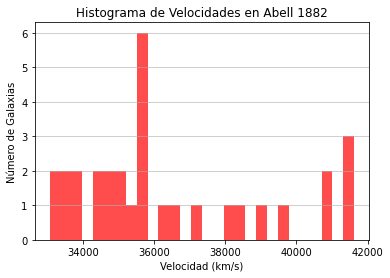

In [28]:
plt.ticklabel_format(style='plain')
plt.hist(concatvel,bins=28, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Velocidades en Abell 1882')
plt.xlabel('Velocidad (km/s)')
plt.ylabel('Número de Galaxias')
plt.savefig('hvelf.png')

In [29]:
ab_ra = 213.809167* 2*np.pi/360
ab_dec = -0.501111 * 2*np.pi/360    
ab_position = [ab_ra, ab_dec]

In [30]:
def dms2dd(dd):
    negative = dd < 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    if negative:
        if degrees > 0:
            degrees = -degrees
        elif minutes > 0:
            minutes = -minutes
        else:
            seconds = -seconds
    return (degrees,minutes,seconds)

In [31]:
decc = galaxias_unicasprom['DEC'].apply(dms2dd)
raa = galaxias_unicasprom['RA'].apply(dms2dd)

In [32]:
ra = galaxias_unicasprom['RA'] * 2*np.pi/360
rra = galaxias_unicasprom['RA']
dec = galaxias_unicasprom['DEC'] * 2*np.pi/360
ddec = galaxias_unicasprom['DEC']
redshift = galaxias_unicasprom['Redshift']

In [33]:
Distancia = (ab_ra-ra)*(2*np.arcsin((np.sin((ab_dec-dec)/2)**2+np.cos(ab_dec)*np.cos(dec)*np.sin((ab_ra-ra)/2)**2)**0.5))*360*60/(2*np.pi)/np.abs(ab_ra-ra)

galaxias_unicasprom = galaxias_unicasprom.assign(Distancia= Distancia)

In [34]:
table= pd.concat([result,gama,galex,df], join="inner")

In [35]:
df

,RA,DEC,Redshift
0,213.80917,-0.50111,0.136700
6,213.81153,-0.49305,0.145314
13,213.80209,-0.51382,0.141000
16,213.81811,-0.48521,0.138000
24,213.82917,-0.50611,0.135000
...,...,...,...
10270,213.94710,-0.98006,0.152682
10301,214.02611,-0.95104,0.138000
10305,213.95360,-0.97937,1.007610
10310,214.07670,-0.92315,0.681938


In [36]:
table = table.drop_duplicates().reset_index(drop=True)

In [37]:
min_ra= 212
max_ra = 216
min_dec= -1.2
max_dec = 0.5
tbfiltrado = table.query('RA >= @min_ra & RA <= @max_ra & DEC >= @min_dec & DEC <= @max_dec').drop_duplicates().reset_index(drop=True)

In [38]:
tb = tbfiltrado[['RA','DEC']]

In [39]:
racord = tb['RA']
racord=pd.to_numeric(racord, errors='coerce')
decord = tb['DEC']
decord=pd.to_numeric(decord, errors='coerce')

Text(0, 0.5, 'DEC (deg)')

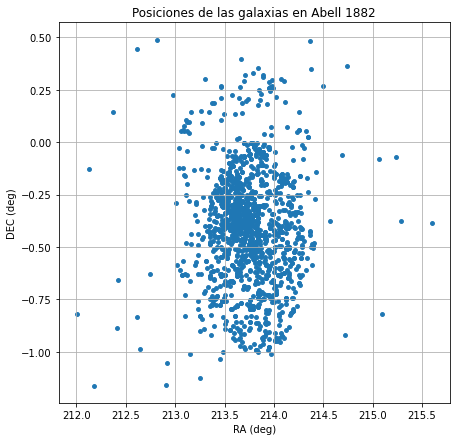

In [40]:
fig = plt.figure(figsize=(7,7))
plt.grid(True)
plt.title('Posiciones de las galaxias en Abell 1882')
plt.scatter(racord,decord,s=15)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')

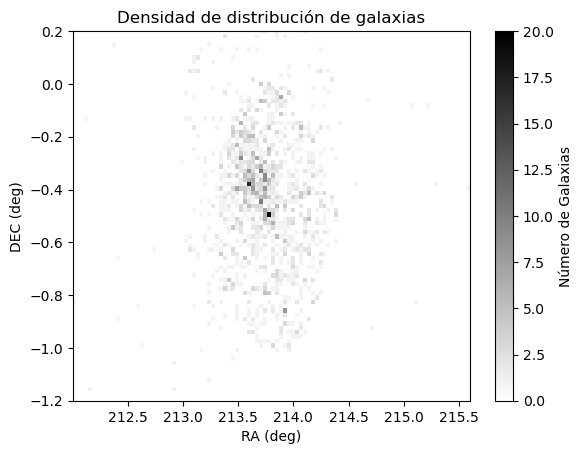

In [41]:
#norm = mpl.colors.Normalize()
with plt.style.context('default'):
    plt.hist2d(racord.dropna().values, decord.dropna().values,bins=100,
               cmap='gray_r')
plt.title('Densidad de distribución de galaxias')
plt.ylim(-1.2,0.2)
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.colorbar(label='Número de Galaxias')

In [42]:
min_red= 0
max_red = 0.5
tbfilred = tbfiltrado[tbfiltrado['Redshift'].between(min_red, max_red)].dropna().drop_duplicates().reset_index(drop=True)

In [43]:
tbfilred=pd.DataFrame(tbfilred)

In [44]:
redshift = tbfilred['Redshift']
redshift=pd.to_numeric(redshift, errors='coerce')
raf = tbfilred['RA']
raf=pd.to_numeric(raf, errors='coerce')
decf = tbfilred['DEC']
decf=pd.to_numeric(decf, errors='coerce')

Text(0, 0.5, 'Número de Galaxias')

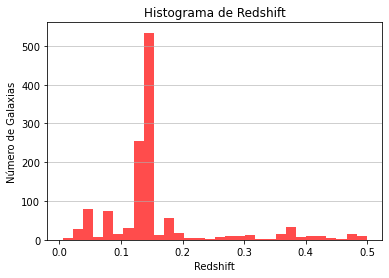

In [45]:
plt.ticklabel_format(style='plain')
plt.hist(redshift,bins=30, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Redshift')
plt.xlabel('Redshift')
plt.ylabel('Número de Galaxias')

In [46]:
mired= 0.11
mared = 0.15
tbfil = tbfilred[tbfilred['Redshift'].between(mired, mared)].dropna().drop_duplicates().reset_index(drop=True)

In [47]:
redsft = tbfil['Redshift']
redsft=pd.to_numeric(redsft, errors='coerce')
raff = tbfil['RA']
raff=pd.to_numeric(raff, errors='coerce')
decff = tbfil['DEC']
decff=pd.to_numeric(decff, errors='coerce')

Text(0, 0.5, 'Número de Galaxias')

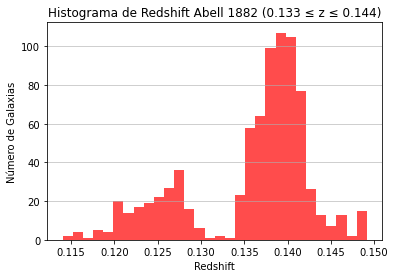

In [48]:
plt.ticklabel_format(style='plain')
plt.hist(redsft,bins=30,color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Redshift Abell 1882 (0.133 ≤ z ≤ 0.144)')
plt.xlabel('Redshift')
plt.ylabel('Número de Galaxias')

In [49]:
# Se definió el número de bins a utilizar en el histograma de velocidades
bins = 30

# Valores máximo y mínimo de las velocidades
minimo = min(redsft)
maximo = max(redsft)

# Cálculo del ancho de cada bin
ancho = (maximo-minimo)/bins

# Función que retorna el número de galaxias cuyas velocidades están en el bin definido entre los valores de velocidades minimun y maximum
def histograma_intervalo(minimum,maximum):
	bin_rsft = redsft.loc[lambda x : (x >= minimum) & (x <= maximum)]
	return len(bin_rsft)

# Función que devuelve la data de los rangos de velocidades de cada bin y los recuentos respectivos de cada uno en un array
def histograma(redsft):
	x = []
	y = []

	for i in range(bins):
		x.append(minimo+i*ancho+ancho/2)
		ret_aux = histograma_intervalo(minimo+i*ancho,minimo+(i+1)*ancho)
		y.append(ret_aux)
        
	x = np.array(x)
	y = np.array(y)
	return np.array([x,y])

In [50]:
histogram_zsp = histograma(redsft)

In [51]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [52]:
histogram_zsp1 = np.copy(histogram_zsp)
histogram_zsp2 = np.copy(histogram_zsp)

In [53]:
def find_position_by_x(arr, x0):
    for i in range(len(arr)):
        if arr[i] > x0:
           	return i-1
n = find_position_by_x(histogram_zsp[0],0.134)

In [54]:
histogram_zsp1[1][16:]=0
histogram_zsp2[1][:16]=0

In [55]:
parameters1, covariance1 = curve_fit(gauss, histogram_zsp1[0], histogram_zsp1[1],p0=[30,0.125,0.003])
parameters2, covariance2 = curve_fit(gauss, histogram_zsp2[0], histogram_zsp2[1],p0=[110,0.138,0.002])

In [56]:
medi1 = parameters1[1]
sigm1 = parameters1[2]
medi2 = parameters2[1]
sigm2 = parameters2[2]

In [57]:
min_lim1 = medi1-3*sigm1
max_lim1 = medi1+3*sigm1
min_lim2 = medi2-3*sigm2
max_lim2 = medi2+3*sigm2

In [58]:
line_values1=[min_lim1,medi1,max_lim1]
line_values2=[min_lim2,medi2,max_lim2]

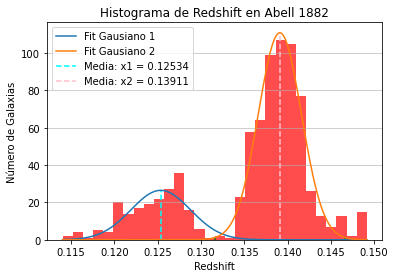

In [59]:
x = np.linspace(minimo,maximo,200)
y1 = gauss(x,*parameters1)
y2 = gauss(x,*parameters2)

plt.ticklabel_format(style='plain')
plt.hist(redsft,bins=30, color='red', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.title('Histograma de Redshift en Abell 1882')
plt.xlabel('Redshift')
plt.ylabel('Número de Galaxias')
plt.plot(x, y1, '-', label='Fit Gausiano 1')
plt.plot(x, y2, '-', label='Fit Gausiano 2')
plt.vlines(line_values1[0],0,gauss(line_values1[0],*parameters1), linestyle='--', color='yellow')
plt.vlines(line_values1[1],0,gauss(line_values1[1],*parameters1), linestyle='--', color='cyan',label='Media: x1 = 0.12534')
plt.vlines(line_values1[2],0,gauss(line_values1[2],*parameters1), linestyle='--', color='yellow')
plt.vlines(line_values2[0],0,gauss(line_values2[0],*parameters2), linestyle='--', color='green')
plt.vlines(line_values2[1],0,gauss(line_values2[1],*parameters2), linestyle='--', color='pink',label='Media: x2 = 0.13911')
plt.vlines(line_values2[2],0,gauss(line_values2[2],*parameters2), linestyle='--', color='green')
plt.legend()

In [60]:
tbfilt1 = tbfil['Redshift'] < 0.134
tbfil1 = tbfil[tbfilt1]

tbfilt2 = tbfil['Redshift'] >= 0.134
tbfil2 = tbfil[tbfilt2]

In [61]:
red1 = tbfil1['Redshift']
red1 = pd.to_numeric(red1, errors='coerce')
ar1 = tbfil1['RA']
ar1 = pd.to_numeric(ar1, errors='coerce')
decl1 = tbfil1['DEC']
decl1=pd.to_numeric(decl1, errors='coerce')

red2 = tbfil2['Redshift']
red2 = pd.to_numeric(red2, errors='coerce')
ar2 = tbfil2['RA']
ar2 = pd.to_numeric(ar2, errors='coerce')
decl2 = tbfil2['DEC']
decl2=pd.to_numeric(decl2, errors='coerce')

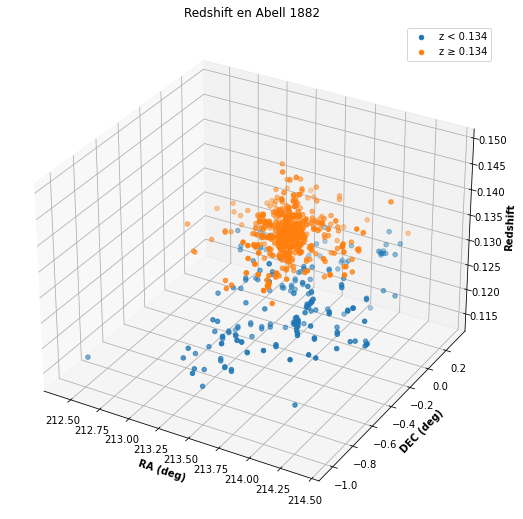

In [62]:
from mpl_toolkits import mplot3d
 
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.3, alpha = 0.2) 

ax.scatter3D(ar1, decl1, red1,  label='z < 0.134')
ax.scatter3D(ar2, decl2, red2, label='z ≥ 0.134')

plt.title("Redshift en Abell 1882")
ax.set_xlabel('RA (deg)', fontweight ='bold') 
ax.set_ylabel('DEC (deg)', fontweight ='bold') 
ax.set_zlabel('Redshift', fontweight ='bold')

ax.legend(loc=1)
plt.show()